In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms
from torchmetrics import Accuracy

from dataset import PersonalityDataset
from params import (
    LocationConfig,
    TrainingConfig,
    WandbConfig,
    NetworkConfig,
)
from models.mlp import MLPsimple
from models.cnn8 import CNN8

In [2]:
train_dataset = PersonalityDataset(Path(LocationConfig.data + 'train/'))
test_dataset = PersonalityDataset(Path(LocationConfig.data + 'test/'))

file: data/ChaLearn/enc/train/train.pickle
file: data/ChaLearn/enc/test/test.pickle


| dataset | data_version | batch_norm | batch_size | dropout | lr | negative_slope | epoch |
| --- | --- | --- | --- | --- | --- | --- | --- |
| BFD | enc | True | 16 | 0.4 | 0.001 | 0.05 | 10 |
| ChaLearn | enc | False | 4 | 0.3 | 0.001 | 0.1 | 12 |

In [3]:
# params = {
#     'lr': 0.001,
#     'batch_norm': True,
#     'negative_slope': 0.05,
#     'dropout': 0.4,
#     'batch_size': 16    
# }

params = {
    'lr': 0.001,
    'batch_norm': False,
    'negative_slope': 0.1,
    'dropout': 0.3,
    'batch_size': 4    
}
num_epochs=12

In [4]:
m=len(train_dataset)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.BCEWithLogitsLoss()
train_accuracy = Accuracy(threshold=0.0)
val_accuracy = Accuracy(threshold=0.0)

dataset = ConcatDataset([train_dataset, test_dataset])


k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [6]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss, train_correct=0.0,0
    model.train()
    for batch in dataloader:
        images, labels = batch['original'], batch['label']
        images = images.to(device)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
        loss = loss_fn(output.flatten(), labels.flatten())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.where(output>0, 1, 0)
        train_correct += (predictions == labels.to(torch.int64)).sum().item()

    return train_loss, train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for batch in dataloader:
        images, labels = batch['original'], batch['label']
        images = images.to(device)
        output = model(images)
        labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
        loss = loss_fn(output.flatten(),labels.flatten())
        valid_loss += loss.item() * images.size(0)
        predictions = torch.where(output>0, 1, 0)
        val_correct += (predictions == labels.to(torch.int64)).sum().item()

    return valid_loss, val_correct

In [7]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = MLPsimple(**params)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / (len(train_loader.sampler) * 5)
        train_acc = train_correct / (len(train_loader.sampler) * 5) * 100
        test_loss = test_loss / (len(test_loader.sampler) * 5)
        test_acc = test_correct / (len(test_loader.sampler) * 5) * 100

        print("Epoch:{}/{} Training Loss:{:.3f} Test Loss:{:.3f} Training Acc {:.2f} % Test Acc {:.2f} %".format(epoch + 1,
                                                                                                                 num_epochs,
                                                                                                                 train_loss,
                                                                                                                 test_loss,
                                                                                                                 train_acc,
                                                                                                                 test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'model/k_cross_BFD_enc.pt')    

Fold 1


<ipython-input-6-25df747a4be3>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
<ipython-input-6-25df747a4be3>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=output.device)


Epoch:1/12 Training Loss:0.124 Test Loss:0.120 Training Acc 65.81 % Test Acc 67.37 %
Epoch:2/12 Training Loss:0.120 Test Loss:0.119 Training Acc 67.79 % Test Acc 68.16 %
Epoch:3/12 Training Loss:0.118 Test Loss:0.117 Training Acc 68.45 % Test Acc 68.81 %
Epoch:4/12 Training Loss:0.117 Test Loss:0.116 Training Acc 68.98 % Test Acc 69.33 %
Epoch:5/12 Training Loss:0.115 Test Loss:0.115 Training Acc 69.50 % Test Acc 69.87 %
Epoch:6/12 Training Loss:0.114 Test Loss:0.114 Training Acc 69.98 % Test Acc 70.20 %
Epoch:7/12 Training Loss:0.113 Test Loss:0.113 Training Acc 70.49 % Test Acc 70.74 %
Epoch:8/12 Training Loss:0.112 Test Loss:0.111 Training Acc 71.04 % Test Acc 71.71 %
Epoch:9/12 Training Loss:0.111 Test Loss:0.112 Training Acc 71.38 % Test Acc 71.29 %
Epoch:10/12 Training Loss:0.110 Test Loss:0.109 Training Acc 71.69 % Test Acc 72.40 %


In [ ]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     


Performance of 10 fold cross validation
Average Training Loss: 0.129 	 Average Test Loss: 0.126 	 Average Training Acc: 61.31 	 Average Test Acc: 65.48


In [ ]:
acc_hist = {}
acc_hist['train_acc'] = history['train_acc']
acc_hist['test_acc'] = history['test_acc']

loss_hist = {}
loss_hist['train_loss'] = history['train_loss']
loss_hist['test_loss'] = history['test_loss']

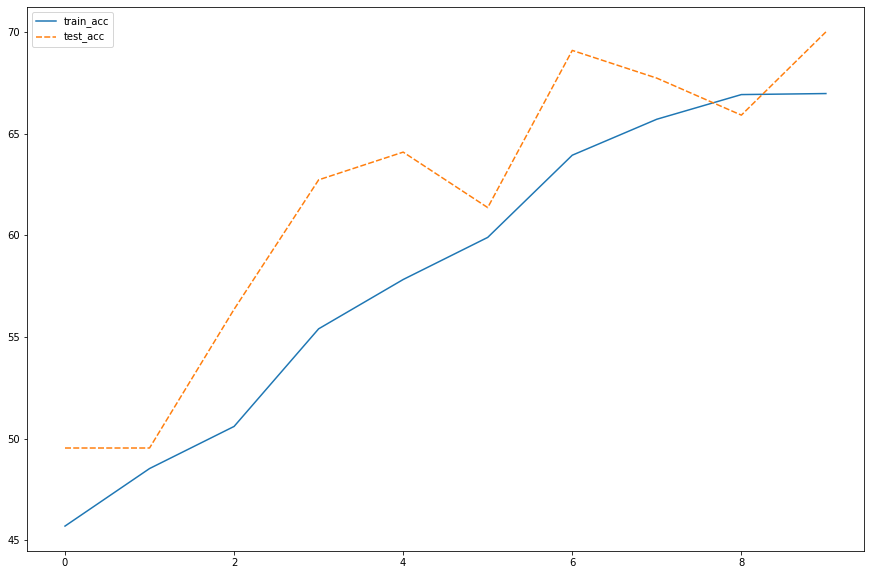

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


labels_font_size = 13
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=acc_hist)
# plt.xlabel("Typ danych", fontsize=labels_font_size)
# plt.ylabel("Dokładność zbioru walidacyjnego", fontsize=labels_font_size)
# plt.xticks(fontsize=labels_font_size) #rotation=10
# plt.yticks(fontsize=labels_font_size)
# plt.title('Dokładność zbioru walidacyjnego a typ danych', fontdict={'fontsize':20});

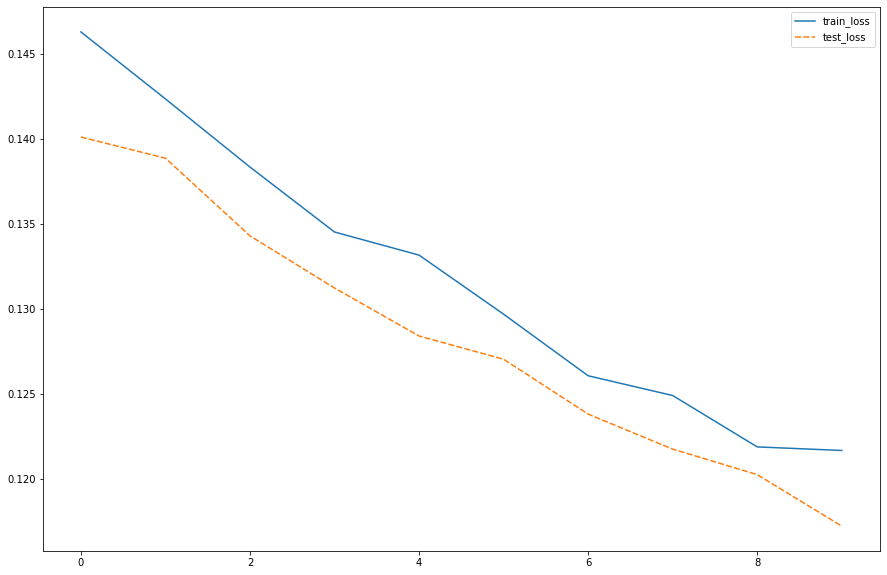

In [ ]:
labels_font_size = 13
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=loss_hist)